# DNA complement and reverse

This notebook was used to benchmark the different approach of computing
the complement of a sequence.

Takes about 15ms to analyse a 1e7 long sequence.


In [1]:
# First, let us create a sequence.
from biokit.sequence.benchmark import SequenceBenchmark

def create_sequence(expectedLength=1e6):
    s = SequenceBenchmark()
    return s.create_sequence(expectedLength)
sequence = create_sequence(1e7)    

## BioPyton

In [2]:
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import GC
seq1 = Seq(sequence, IUPAC.unambiguous_dna)
GC(seq1)

44.0

In [3]:
%%timeit -n 3
seq1 = Seq(sequence, IUPAC.unambiguous_dna)
res = seq1.complement()


3 loops, best of 3: 9.09 ms per loop


In [4]:
len(seq1)

10000000

## Python with lists

In [5]:
class DNAList(object):
    bases = ["A", "C", "T", "G"]
    cbases = {"T":"A", "G":"C", "A":"T", "C":"G"}
    def __init__(self, data):
        self.data = data[:]
    def get_complement(self):
        res = "".join((self.cbases[x] for x in self))
        return res 
    def __getitem__(self, index):
        if type(index) == slice:
            return "".join(self.data[index])
        return self.data[index]

In [6]:
seq2 = DNAList(sequence[0:1000000])  # slow

In [7]:
%%timeit -n 3
res = seq2.get_complement()

3 loops, best of 3: 396 ms per loop


## Python with strings

This is a simplified version of what is done in BioPython and BioKit

In [8]:
import string
# with strings as ACGT / TGCA, there is no improvment
trans = string.maketrans('ACGTagct', 'TGCAtgca')
class DNA(object):
    def __init__(self, sequence):
        self.sequence = sequence
    def complement(self):
        return self.sequence.translate(trans)
d = DNA(sequence)


AttributeError: module 'string' has no attribute 'maketrans'

In [ ]:
%%timeit -n 3
res = d.complement()
#fh = open("test.fasta", "w")
#fh.write(res)
#fh.close()

### dictionary

In [12]:
class DNAdict(object):
    def __init__(self, sequence):
        self.sequence = sequence
        
    def complement(self, k=1):
        # works with even length for now
        mapping = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
        
        import itertools
        combi = ["".join(x) for x in list(itertools.product('ACGT', repeat=k))]
        newmap = dict([(comb, "".join([mapping[x] for x in comb])) for comb in combi])
        
        N = len(self.sequence)/k
        sequence = "".join([ newmap[self.sequence[i*k:i*k+k]] for i in range(0,N)])
        return sequence
d = DNAdict(create_sequence(1e6))

In [13]:
%%timeit -n 3
res = d.complement()

TypeError: 'float' object cannot be interpreted as an integer

In [10]:
%%timeit -n 3
res = d.complement(k=2)

NameError: name 'd' is not defined

In [11]:
%%timeit -n 3
res = d.complement(k=3)

NameError: name 'd' is not defined

In [14]:
%%timeit -n 3
res = d.complement(k=6)
# 6 seems to be the best but at the end, it is slower than maketrans

3 loops, best of 3: 82.5 ms per loop


## Another way with Pandas?

In [14]:
import pandas as pd

In [15]:
d = pd.TimeSeries(sequence)
# here we just store the sequence so the timeseries is 
# just a container. Instanciation is 50 times longer 
# than a simple class storing the sequence as a string though
import string
trans = string.maketrans('ACGTacgt', 'TGCAtgca')

/home/cokelaer/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: TimeSeries is deprecated. Please use Series
  if __name__ == '__main__':


AttributeError: module 'string' has no attribute 'maketrans'

In [16]:
%%timeit -n 3
res = "".join(d).translate(trans)

NameError: name 'trans' is not defined

## BioKit

In [18]:
from biokit.sequence import dna
reload(dna)


coudl not install lib
could not install lib
coudl not install lib


<module 'biokit.sequence.dna' from '/home/cokelaer/Work/github/biokit/biokit/sequence/dna.pyc'>

In [19]:
d = dna.DNA(sequence)

In [20]:
%%timeit -n 10
# maketrans
d.get_complement()

10 loops, best of 3: 16.3 ms per loop


## cython test

- Cythonise does not make it faster. probably the reason being that maketrans  is alredy optimised
- THe code below provides a cython version of the code implemented earlier (CyTransSeq) and a cythonised version of a dictionary implementation.
- Neither are faster than the maketrans
- lookup and lut table do not help either
- references: http://nbviewer.ipython.org/urls/gist.github.com/Jorge-C/d51b48d3e18897c46ea2/raw/73d7e11e4b72d6ba90e0021931afa230e63031e9/cython+sequences.ipynb?create=1

In [21]:
%load_ext cythonmagic


In [22]:
%%cython --annotate
# source http://nbviewer.ipython.org/urls/gist.github.com/Jorge-C/d51b48d3e18897c46ea2/raw/73d7e11e4b72d6ba90e0021931afa230e63031e9/cython+sequences.ipynb?create=1
cimport cython
import string
import numpy as np
cimport numpy as cnp

table = string.maketrans(b'ACGTacgt',
                        b'TGCAtgca')

cdef class CyTransSeq(object):
    """Simply defining the class as a cython one, uses translation table"""
    cdef public str seq

    def __cinit__(self, seq):
        self.seq = seq

    cpdef rc(self):
        return list(reversed(self.seq.translate(table)))
    
    cpdef complement(self):
        return self.seq.translate(table)

cdef class CySeq(object):
    """Translation using a dict, cythonized"""
    _complement_map = {
        'A': 'T', 'C':'G', 'G':'C', 'T':'A',
        'a': 't', 'c':'g', 'g':'c', 't':'a'}
    cdef public str seq
    
    def __cinit__(self, seq):
        self.seq = seq

    cdef _rc(self):
        result = []
        for base in reversed(self.seq):
            result.append(self._complement_map[base])
        return result
    
    cdef _complement1(self):
        result = []
        for base in self.seq:
            result.append(self._complement_map[base])
        return result
    def complement1(self):
        return self._complement1()
    def complement2(self):
        return self._complement2()
        
    cdef _complement2(self):
        return [self._complement_map[base] for base in self.seq]

    def rc(self):
        return self._rc()



In [23]:
seq = CyTransSeq(sequence)

In [24]:
%%timeit -n 3
res = seq.complement()

3 loops, best of 3: 17 ms per loop


## Plot

In [25]:
import matplotlib as plt
%matplotlib
import pylab

Using matplotlib backend: Qt4Agg


In [27]:
N = [1e5, 1e6, 5e6, 1e7, 5e7, 1e8]
import time
timesBioKit = []
timesC = []
timesBio = []
timesCyt = []
reload(dna)
for el in N:
    # BioKit
    factor = int(el / 50.) #100 is the length of the small string
    subseq = "AGCTTTTCATTCTGACTGCAACGGGCAATATGTCAGTGTCTCGTTGCAAA"
    sequence_in = "".join([subseq]*factor)
    seq = dna.DNA(sequence_in)
    t1 = time.time()
    res = seq.get_complement()
    t2 = time.time()
    timesBioKit.append(t2-t1)
    
    #t1 = time.time()
    #res = seq.get_complement_c()
    #t2 = time.time()
    #timesC.append(t2-t1)
    
    
    # biopython
    seqbio = Seq(sequence_in, IUPAC.unambiguous_dna)
    t1 = time.time()
    seqbio.complement()
    t2 = time.time()
    timesBio.append(t2-t1)
    
    # cython
    seqcyt = CyTransSeq(sequence_in)
    t1 = time.time()
    seqcyt.complement()
    t2 = time.time()
    timesCyt.append(t2-t1)
    
    
    print el
    

100000.0
1000000.0
5000000.0
10000000.0
50000000.0
100000000.0


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


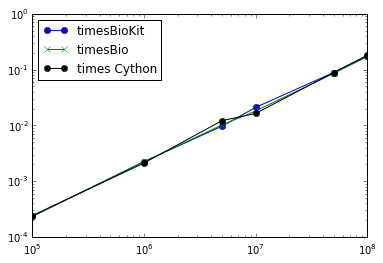

In [28]:
%pylab inline
pylab.clf()
pylab.loglog(N, timesBioKit, 'o-', N, timesBio, 'gx-', 
             N, timesCyt, 
             'ko-')
pylab.legend(['timesBioKit', 'timesBio', 'times Cython'], 
             loc='best')